In [31]:
import pandas as pd

import matplotlib.pyplot as plt

import numpy as np


import xgboost as xgb

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, atpe

from sklearn.metrics import roc_auc_score

import gc

from sklearn.model_selection import GroupShuffleSplit, train_test_split, LeavePGroupsOut

from sklearn.metrics import precision_recall_curve, roc_curve


In [2]:
df = pd.read_csv('data/mafat_wifi_challenge_training_set_v1.csv')

In [3]:
df.head()

,Time,Room_Num,Device_ID,RSSI_Left,RSSI_Right,Num_People
0,0.0,3,92178,-42,-51,2.0
1,0.5,3,92178,-42,-51,2.0
2,1.0,3,92178,-42,-51,2.0
3,1.5,3,92178,-42,-51,2.0
4,2.0,3,92178,-42,-51,2.0


In [4]:
("Data recorded from %d devices"%df['Device_ID'].nunique())

'Data recorded from 84 devices'

In [5]:
print("No. of People that can be in the room", df.Num_People.unique().tolist())

No. of People that can be in the room [2.0, 1.0, 0.0, 3.0]


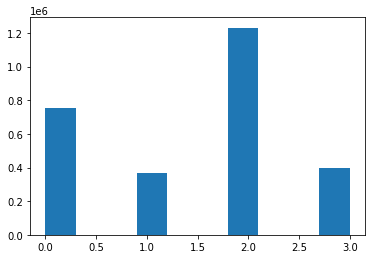

In [6]:
plt.hist(df.Num_People);

We want to create some new features for each device and room like:
- difference in signal strength of the 2 antennas
- RMS of the signal strength
- Change in each of original features as well as derived features per observation

Then we want to do rolling z-norm to get the actual features the model will be trained on.

We also want to divide it into chunks of 360 observations (3 minutes) because that's what the evaluation is going to be on


In [7]:
import tqdm

In [8]:
chunks_df = []
S = 360
periods=[30, 60, 90, 150, 240, 300]
# periods=[25, 75, 125, 100, 175, 200, 225, 275, 300, 325]
# periods=[10, 15, 25, 50, 100, 150, 200, 250, 300]

for (room, device), room_device_group in tqdm.tqdm(df.groupby(['Room_Num','Device_ID'])):
    N = int(len(room_device_group)/S)
    
    for i in range(N+1):
        chunk = room_device_group.iloc[i*S:(i+1)*S].copy()
        
        # chunk['chunk_id'] = str(room)+'_'+str(device)+'_'+str(i)

        chunk['RSSI_diff'] = chunk.RSSI_Left - chunk.RSSI_Right
        chunk['RSSI_Left_diff'] = chunk.RSSI_Left.diff()
        chunk['RSSI_diff_diff'] = chunk.RSSI_diff.abs().diff()
        chunk['RSSI_Right_diff'] = chunk.RSSI_Right.diff()
        chunk['RSSI_rms'] = np.sqrt(chunk.RSSI_Left**2 + chunk.RSSI_Right**2)
        chunk['RSSI_rms_diff'] = chunk.RSSI_Right.diff()

        for col_name in [#'RSSI_Left', 'RSSI_Right', 
                         'RSSI_diff', 'RSSI_rms', 
                         'RSSI_Left_diff', 'RSSI_Right_diff', 'RSSI_rms_diff', 'RSSI_diff_diff']:
           
            for period in periods:
                feature_std = (chunk[col_name].rolling(period, min_periods=0).std()).fillna(0.0000000001)
                feature_mean = chunk[col_name].rolling(period, min_periods=0).mean()
                feature_max = chunk[col_name].rolling(period, min_periods=0).max()
                feature_min = chunk[col_name].rolling(period, min_periods=0).min()
                
                chunk[col_name+'_'+str(period)] = (chunk[col_name] - feature_mean)/feature_std
                chunk[col_name+'_'+str(period)+'_range'] = (feature_max - feature_min)/feature_std
                chunk[col_name+'_'+str(period)+'_skew'] = (feature_mean - (feature_max - feature_min)/2)/feature_std
                
        chunk.drop(['RSSI_Left', 'RSSI_Right', 'RSSI_diff', 'RSSI_rms', 
                         'RSSI_Left_diff', 'RSSI_Right_diff', 'RSSI_rms_diff', 'RSSI_diff_diff'], axis=1, inplace=True)
        
        chunk['people_present'] = int((chunk['Num_People']!=0).any())
        chunk['chunk_id'] = str(room)+'_'+str(device)+'_'+str(i)
#         data = {}
#         for col_name in chunk.columns[chunk.columns.str.startswith('RSSI')]:
#                 data[col_name+'_max'] = chunk[col_name].max()
#                 data[col_name+'_min'] = chunk[col_name].min()
#                 data['people_present'] = int((chunk['Num_People']!=0).any())
#                 data['chunk_id'] = str(room)+'_'+str(device)+'_'+str(i)
#         chunks_df.append(data)
        chunks_df.append(chunk)
        

chunks_df = pd.concat(chunks_df)
# chunks_df = pd.DataFrame(chunks_df)

 25%|███████████████████████████████████████████▌                                                                                                                                  | 21/84 [03:11<09:34,  9.13s/it]


KeyboardInterrupt: 

In [ ]:
chunks_df.shape

In [ ]:
chunks_df.drop(['Time',
                'Room_Num',
                'Device_ID'], axis=1, inplace=True)

In [11]:
# Remove the original data to save memory
del df

In [12]:
feature_cols = chunks_df.columns[chunks_df.columns.str.startswith('RSSI')]
# Remove the original features
# feature_cols = feature_cols[~feature_cols.isin(['RSSI_Left', 'RSSI_Right', 'RSSI_diff', 'RSSI_rms', 'RSSI_Left_diff', 'RSSI_Right_diff', 'RSSI_rms_diff', 'RSSI_diff_diff'])]

In [13]:
# chunks_df = chunks_df[['chunk_id']+feature_cols.tolist()+['people_present']]

In [14]:
chunks_df.reset_index(drop=True, inplace=True)

In [15]:
chunks_df.people_present.sum()/chunks_df.shape[0]

0.7533582119427515

Slightly more skewed towards people present

In [16]:
chunks_df.replace([np.inf, -np.inf], 0, inplace=True)

In [18]:
splitter = GroupShuffleSplit(test_size=.5, n_splits=2, random_state = 42)
split = splitter.split(chunks_df, groups=chunks_df['chunk_id'])
train_idx, eval_idx = next(split)

x_train, y_train = chunks_df.loc[train_idx, feature_cols], chunks_df.loc[train_idx, 'people_present']

split = splitter.split(chunks_df.iloc[eval_idx], groups=chunks_df.loc[eval_idx, 'chunk_id'])
val_idx, test_idx = next(split)

x_val, y_val = chunks_df.loc[val_idx, feature_cols], chunks_df.loc[val_idx, 'people_present']

x_test, y_test = chunks_df.loc[test_idx, feature_cols], chunks_df.loc[test_idx, 'people_present']

In [19]:
len(x_train), len(x_val), len(x_test)

(1371508, 687672, 688562)

In [21]:
SEED = 42

In [22]:
gc.collect()

0

In [23]:
splitter = LeavePGroupsOut(n_groups=chunks_df['chunk_id'].nunique()//2)
split = splitter.split(chunks_df, groups=chunks_df['chunk_id'])
train_idx, eval_idx = next(split)


In [ ]:

def score(params):
    # print("Training with params: ")
    # print(params)
    train_idx, eval_idx = next(split)
    x_train, y_train, id_train = chunks_df.loc[train_idx, feature_cols], chunks_df.loc[train_idx, 'people_present'], chunks_df.loc[train_idx, 'chunk_id']
    x_val, y_val, id_val = chunks_df.loc[eval_idx, feature_cols], chunks_df.loc[eval_idx, 'people_present'], chunks_df.loc[eval_idx, 'chunk_id']

    model = xgb.XGBClassifier(**params)
    model = model.fit(x_train, y_train)
    predictions = model.predict_proba(x_val)
    score = roc_auc_score(y_val,predictions[:,1])
    # TODO: Add the importance for the selected features
    
    print("Training with params: ")
    print(model.get_params())
    print("\tScore {0}\n\n".format(score))
    
    
    del model
    gc.collect()
    
    # The score function should return the loss (1-score)
    # since the optimize function looks for the minimum
    
    loss = 1 - score
    return {'loss': loss, 'status': STATUS_OK}


def optimize(
             #trials, 
             random_state=SEED):
    """
    This is the optimization function that given a space (space here) of 
    hyperparameters and a scoring function (score here), finds the best hyperparameters.
    """
    # To learn more about XGBoost parameters, head to this page: 
    # https://github.com/dmlc/xgboost/blob/master/doc/parameter.md
    space = {
        'n_estimators': hp.uniformint('n_estimators', 100, 225),
        'eta': hp.quniform('eta', 0.025, 0.5, 0.025),        
        'max_depth':  hp.uniformint('max_depth', 10, 30),
        'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
        'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
        'grow_policy':'lossguide',
        'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
        'colsample_bylevel': hp.quniform('colsample_bylevel', 0.5, 1, 0.05),
        'colsample_bynode': hp.quniform('colsample_bynode', 0.5, 1, 0.05),
        'lambda':hp.quniform('lambda', 0.1, 1, 0.1),
        # 'lambda':0,
        'alpha':hp.quniform('alpha', 0.1, 1, 0.1),
        'eval_metric': 'auc',
        'objective': 'binary:logistic',
        'single_precision_histogram': True,
        # 'num_parallel_tree': hp.uniformint('num_parallel_tree', 1, 30),
        # 'num_parallel_tree': 1,
        # Increase this number if you have more cores. Otherwise, remove it and it will default 
        # to the maxium number. 
        # 'nthread': 4,
        
        'booster': 'gbtree',
        'tree_method': 'hist',
        'max_leaves': 5000,
        'missing': np.nan,
        'seed': random_state
    }
    # Use the fmin function from Hyperopt to find the best hyperparameters
    best = fmin(score, space, algo=tpe.suggest, 
                # trials=trials, 
                max_evals=100)
    return best

#-------------------------------------------------#

#-------------------------------------------------#

# Run the optimization

# Trials object where the history of search will be stored
# For the time being, there is a bug with the following version of hyperopt.
# You can read the error messag on the log file.
# For the curious, you can read more about it here: https://github.com/hyperopt/hyperopt/issues/234
# => So I am commenting it.
# trials = Trials()

best_hyperparams = optimize(
                            #trials
                            )
print("The best hyperparameters are: ", "\n")
print(best_hyperparams)

  0%|                                                                                                                                                                      | 0/100 [00:00<?, ?trial/s, best loss=?]

In [ ]:
feature_cols.tolist()

In [24]:
params = {'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': 0.5, 'booster': 'gbtree', 'callbacks': None, 
          'colsample_bylevel': 0.9, 'colsample_bynode': 0.7, 'colsample_bytree': 0.8, 'early_stopping_rounds': None, 
          'enable_categorical': False, 'eval_metric': 'auc', 'gamma': 0.7, 'gpu_id': -1, 'grow_policy': 'lossguide', 
          'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.075, 'max_bin': 256, 'max_cat_to_onehot': 4, 
          'max_delta_step': 0, 'max_depth': 30, 'max_leaves': 5000, 'min_child_weight': 4.0, 'missing': np.nan, 'monotone_constraints': '()', 
          'n_estimators': 188, 'n_jobs': 0, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 42, 'reg_alpha': 0.5, 
          'reg_lambda': 0.5, 'sampling_method': 'uniform', 'scale_pos_weight': 1, 'subsample': 0.8, 'tree_method': 
          'hist', 'validate_parameters': 1, 'verbosity': None, 'alpha': 0.5, 'eta': 0.075, 'lambda': 0.5, 'seed': 42, 
          'single_precision_histogram': True}

In [24]:
params = {'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': 0.5, 'booster': 'gbtree', 'callbacks': None, 
          'colsample_bylevel': 0.55, 'colsample_bynode': 0.6, 'colsample_bytree': 0.6, 'early_stopping_rounds': None, 
          'enable_categorical': False, 'eval_metric': 'auc', 'gamma': 0.7, 'gpu_id': -1, 'grow_policy': 'lossguide', 
          'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.075, 'max_bin': 256, 'max_cat_to_onehot': 4, 
          'max_delta_step': 0, 'max_depth': 29, 'max_leaves': 5000, 'min_child_weight': 5.0, 'missing': np.nan, 'monotone_constraints': '()',
          'n_estimators': 178, 'n_jobs': 0, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 42, 'reg_alpha': 0.1,
          'reg_lambda': 0.300000012, 'sampling_method': 'uniform', 'scale_pos_weight': 1, 'subsample': 0.85,
          'tree_method': 'hist', 'validate_parameters': 1, 'verbosity': None, 'alpha': 0.1, 'eta': 0.075, 'lambda': 0.3, 
          'seed': 42, 'single_precision_histogram': True}

In [45]:
# best_hyperparams['n_estimators'] = int(best_hyperparams['n_estimators'])

# best_hyperparams['num_parallel_tree'] = int(best_hyperparams['num_parallel_tree'])

# best_hyperparams['max_depth'] = int(best_hyperparams['max_depth'])

In [25]:

model = xgb.XGBClassifier(**params)

In [26]:
model.fit(x_train, y_train)

XGBClassifier(alpha=0.1, base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=0.55, colsample_bynode=0.6,
              colsample_bytree=0.6, early_stopping_rounds=None,
              enable_categorical=False, eta=0.075, eval_metric='auc', gamma=0.7,
              gpu_id=-1, grow_policy='lossguide', importance_type=None,
              interaction_constraints='', lambda=0.3, learning_rate=0.075,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=29,
              max_leaves=5000, min_child_weight=5.0, missing=nan,
              monotone_constraints='()', n_estimators=178, n_jobs=0,
              num_parallel_tree=1, predictor='auto', ...)

In [27]:
val_pred = model.predict_proba(x_val)

In [28]:
roc_auc_score(y_val,val_pred[:,1])

0.8929371026061663

In [29]:
test_pred = model.predict_proba(x_test)

In [30]:
roc_auc_score(y_test,test_pred[:,1])

0.8895448115506173

In [32]:
precision, recall, thresholds = precision_recall_curve(y_test,test_pred[:,1])

In [33]:
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)

In [34]:
fscore[ix], thresholds[ix]

(0.9315272317507552, 0.21203877)

In [35]:
fpr, tpr, thresholds = roc_curve(y_test,test_pred[:,1])

In [36]:
tnr = 1-fpr

In [37]:
thresholds[(tpr+tnr).argmax()]

0.8592636

In [38]:
(test_pred[:,1]>0.21).mean()

0.9144361727774696

In [39]:
y_test.mean()

0.8152875122356448

In [40]:
feature_importance = model.feature_importances_

(array([16., 28., 27., 11., 16.,  2.,  4.,  2.,  0.,  2.]),
 array([0.00401397, 0.00591831, 0.00782264, 0.00972698, 0.01163131,
        0.01353565, 0.01543998, 0.01734432, 0.01924866, 0.02115299,
        0.02305732], dtype=float32),
 <BarContainer object of 10 artists>)

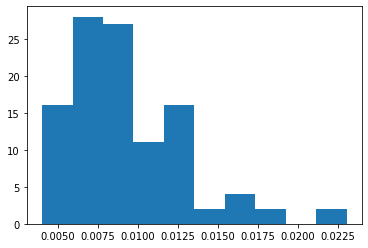

In [41]:
plt.hist(feature_importance)

In [42]:
selected_cols = feature_cols[feature_importance.argsort()[::-1]][:225]

In [43]:
selected_cols = feature_cols[feature_importance>0]

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

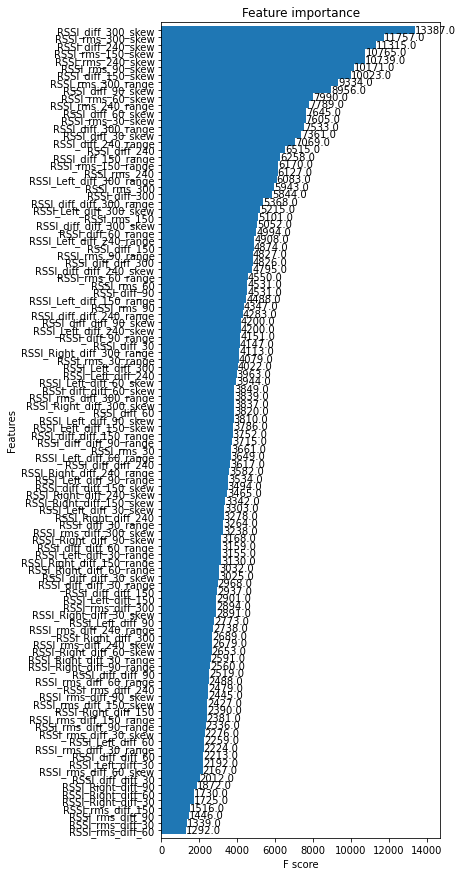

In [44]:
fig, ax = plt.subplots(1)

fig.set_size_inches(5,15)

# ax = plt.figure(figsize=(10,5))

xgb.plot_importance(model, 
                    # importance_type='gain',
                    importance_type='weight', 
                    grid=False, 
                    height=1,
                    ax=ax)

In [45]:
chunks_df.chunk_id.nunique()

7682

In [61]:
splitter = LeavePGroupsOut(n_groups=1600)
split = splitter.split(chunks_df, groups=chunks_df['chunk_id'])
train_idx, eval_idx = next(split)

x_train, y_train, id_train = chunks_df.loc[train_idx, feature_cols], chunks_df.loc[train_idx, 'people_present'], chunks_df.loc[train_idx, 'chunk_id']


x_val, y_val, id_val = chunks_df.loc[eval_idx, feature_cols], chunks_df.loc[eval_idx, 'people_present'], chunks_df.loc[eval_idx, 'chunk_id']


In [ ]:
model = xgb.XGBClassifier(**params)

model.fit(x_train, y_train)

val_pred = model.predict_proba(x_val)

In [ ]:
roc_auc_score(y_val,val_pred[:,1])

In [56]:
chunks_df.chunk_id.head()

0    1_410_0
1    1_410_0
2    1_410_0
3    1_410_0
4    1_410_0
Name: chunk_id, dtype: object

In [25]:

model = xgb.XGBClassifier(**params)

In [26]:
model.fit(x_train, y_train)

XGBClassifier(alpha=0.1, base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=0.55, colsample_bynode=0.6,
              colsample_bytree=0.6, early_stopping_rounds=None,
              enable_categorical=False, eta=0.075, eval_metric='auc', gamma=0.7,
              gpu_id=-1, grow_policy='lossguide', importance_type=None,
              interaction_constraints='', lambda=0.3, learning_rate=0.075,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=29,
              max_leaves=5000, min_child_weight=5.0, missing=nan,
              monotone_constraints='()', n_estimators=178, n_jobs=0,
              num_parallel_tree=1, predictor='auto', ...)

In [27]:
val_pred = model.predict_proba(x_val)

In [28]:
roc_auc_score(y_val,val_pred[:,1])

0.8929371026061663

In [60]:
id_val[(y_val - val_pred[:,1])>0.5]

379           1_410_1
383           1_410_1
390           1_410_1
391           1_410_1
392           1_410_1
              ...    
1359977     3_80218_2
1365042    3_80218_17
1365044    3_80218_17
1365046    3_80218_17
1365048    3_80218_17
Name: chunk_id, Length: 130148, dtype: object

In [49]:
model.save_model('models/tree_booster3.bin')

In [9]:
load_model = xgb.XGBClassifier()

NameError: name 'xgb' is not defined

In [136]:
load_model.load_model('submission/tree_booster2.bin')

In [137]:
load_model.n_features_in_

324